In [1]:
include("src/Sim.jl")

Main.Sim

In [2]:
using DifferentialEquations
using Plots
using .Sim

In [34]:
@model testSatu begin
    @parameter #=V_A_max=# V_A_min alpha_A
    
    @blk In = InBlock()
    #@blk Saturation = SaturationBlock(upperlimit=V_A_max, lowerlimit=V_A_min) outport:sss
    @blk Quan = QuantizerBlock(interval=1)
    @blk Constant = ConstantBlock(V_A_min)
    @blk Gain = GainBlock(alpha_A)
    @blk Out = OutBlock()
    
    #@connect In => Saturation
    #@connect Saturation - Constant => Gain
    @connect In - Constant => Gain
    @connect Gain => Quan
    @connect Quan => Out
    #@connect Gain => Out
end

testSatu (generic function with 1 method)

In [38]:
@model test1 begin
    @parameter V_A_max V_A_min u_M_d n
    
    @blk Ramp = RampBlock(slope=u_M_d, starttime=0, initialoutput=-5) outport:u_M
    @blk Saturation = SaturationBlock(upperlimit=V_A_max, lowerlimit=V_A_min) outport:sss
    @blk Satu = testSatu(V_A_min=V_A_min, alpha_A=(2^(n)-1)/(V_A_max-V_A_min)) outport:d_A
    
    @connect u_M => Saturation
    @connect sss => Satu
end

test1 (generic function with 1 method)

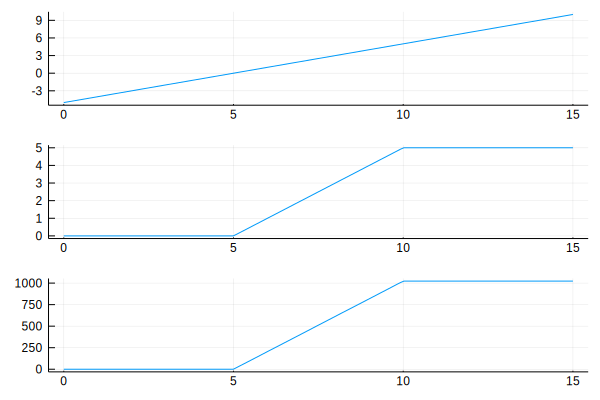

In [39]:
m = test1(V_A_max=5, V_A_min=0, u_M_d=1, n=10)
sol = @simulate(m, tspan = (0.0, 15.0), scope=[u_M, sss, d_A])
sol.graph

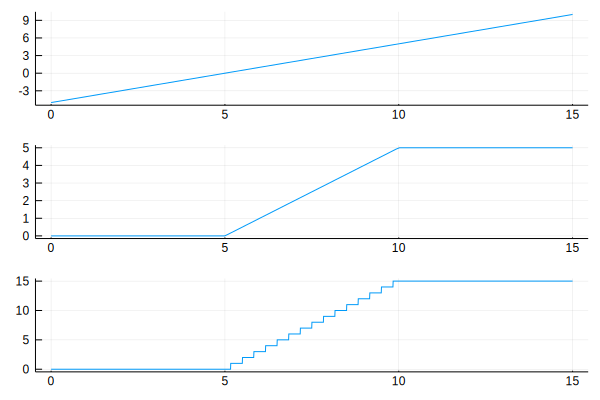

In [40]:
m1 = test1(V_A_max=5, V_A_min=0, u_M_d=1, n=4)
sol = @simulate(m1, tspan = (0.0, 15.0), scope=[u_M, sss, d_A])
sol.graph

In [17]:
lower=1
upper=10
y=5
x=Expr(:if, Expr(:comparison, lower, :>=, y), lower, Expr(:if, Expr(:comparison, upper, :<=, y), upper, y))

:(if 1 >= 5
      1
  else
      if 10 <= 5
          10
      else
          5
      end
  end)

In [8]:
eval(x)

5

In [42]:
mod(23, 5)

3

In [1]:
interval = 2
Expr(:call, :*, interval, round(10/interval))

:(2 * 5.0)

In [3]:
@model testQuantizer begin
    @parameter 
    
    @blk Quan = QuantizerBlock(interval=1.0)
    @blk In = InBlock()
    @blk Out = OutBlock()
    
    @connect In => Quan
    @connect Quan => Out
end

testQuantizer (generic function with 1 method)

In [4]:
@model tQ begin
    @parameter
    
    @blk Ramp = RampBlock(slope=1.0, starttime=0.0, initialoutput=-5.0) outport:ramp
    @blk TQ = testQuantizer() outport:TQu
    
    @connect ramp => TQ
end

tQ (generic function with 1 method)

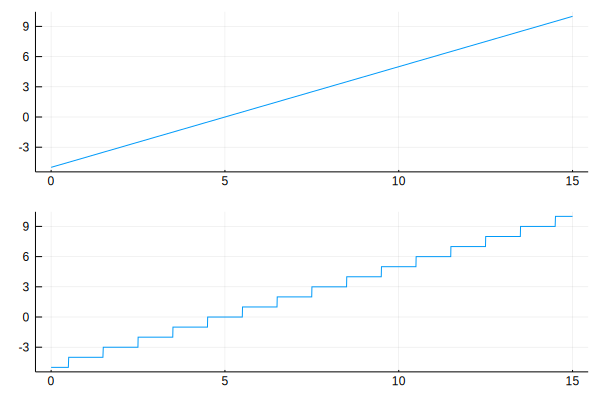

In [5]:
m = tQ()
sol = @simulate(m, tspan = (0.0, 15.0), scope=[ramp, TQu])
sol.graph

In [9]:
@model PulseGenerator begin
    @parameter m alpha_P
    
    @blk In = InBlock()
    @blk Quantizer = QuantizerBlock(interval=1)
    @blk Constant = ConstantBlock(2^m)
    @blk Mod = ModBlock() inport[1]:in1 inport[2]:in2
    @blk Gain = GainBlock(alpha_P)
    @blk Out = OutBlock()
    
    @connect In => Quantizer
    @connect Quantizer  => in1
    @connect Constant => in2
    @connect Mod => Gain
    @connect Gain => Out
end

controllerModel (generic function with 1 method)

In [10]:
@model CM begin
    @parameter m d_P_d
    
    @blk Ramp = RampBlock(slope=d_P_d, starttime=0, initialoutput=-50) outport:d_P
    @blk cm = PulseGenerator(m=m, alpha_P=100/(2^m-1)) outport:u_P
    
    @connect d_P => cm
end

CM (generic function with 1 method)

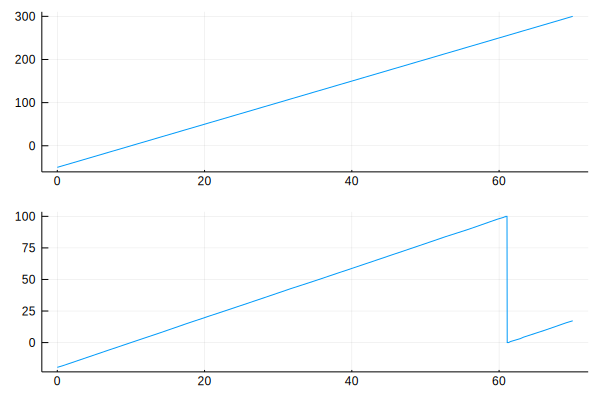

In [14]:
m = CM(m=8, d_P_d=5)
sol = @simulate(m, tspan = (0.0, 70.0), scope=[d_P, u_P])
sol.graph